Feature Analysis on cellular responses to drug treatments

In [ ]:
import numpy as np
import pandas as pd
from skimage.measure import regionptzstableptzsptzsptzsptzsptzsptzsptzsptzsptzsptzsptzsptzsptzsptzs

Cell segmentation and feature extraction tools can increase the accuracy in drug classification. In the codes following, we use RGB to highlight the segmentation cells from the mask images. And the mask images is pretrained using Cellpose.

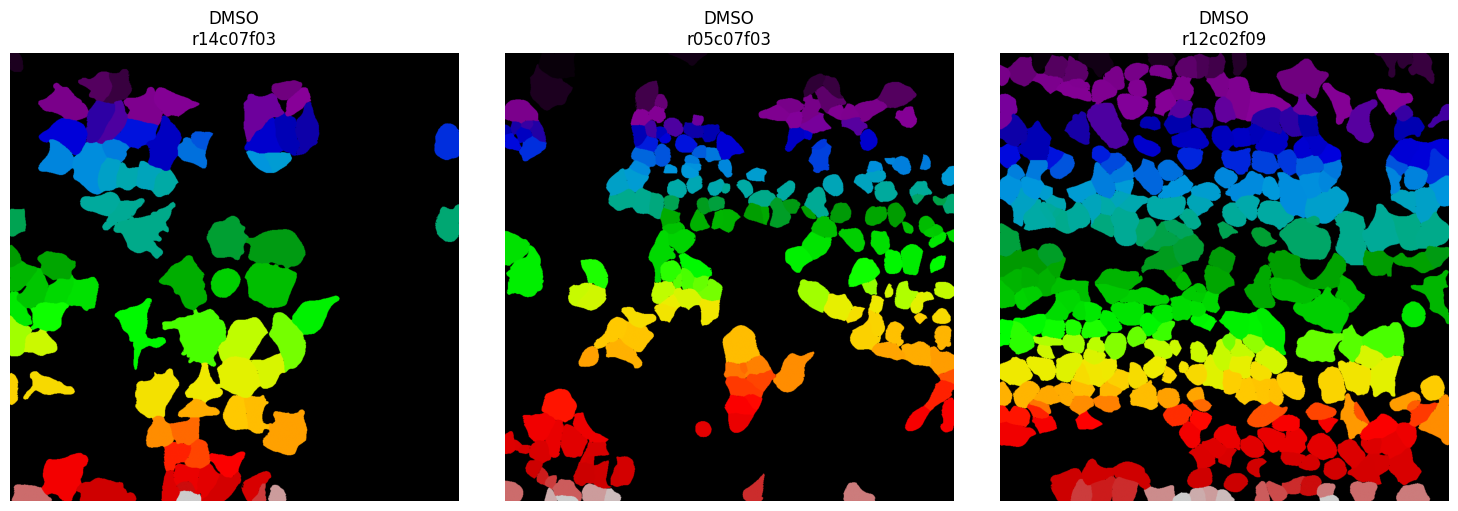

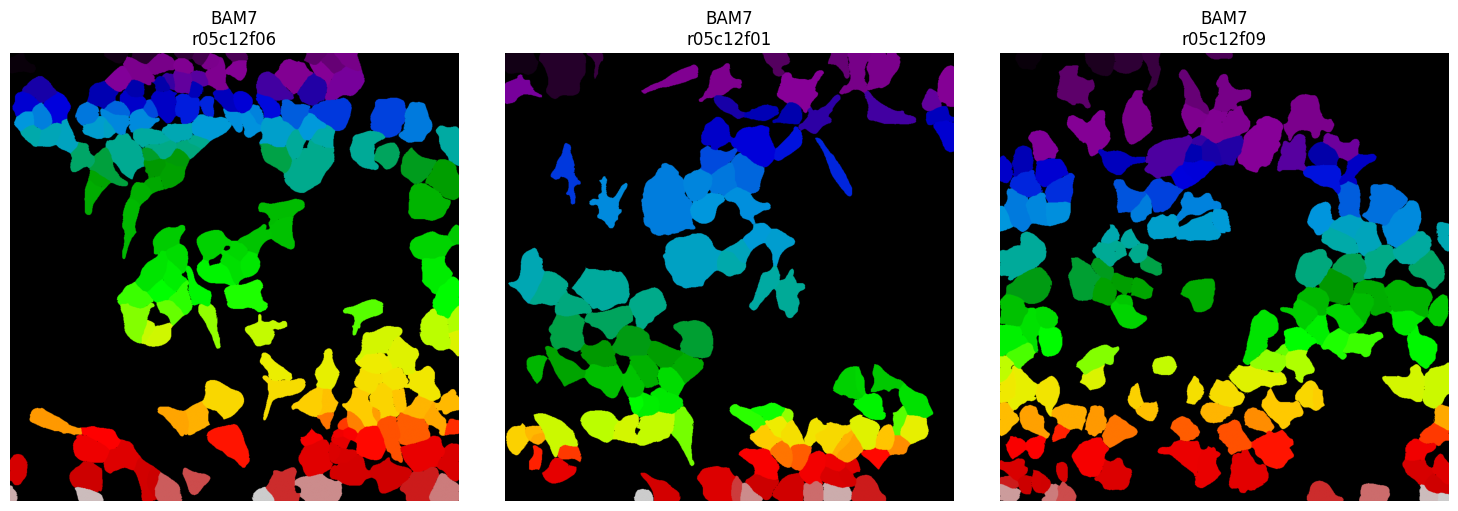

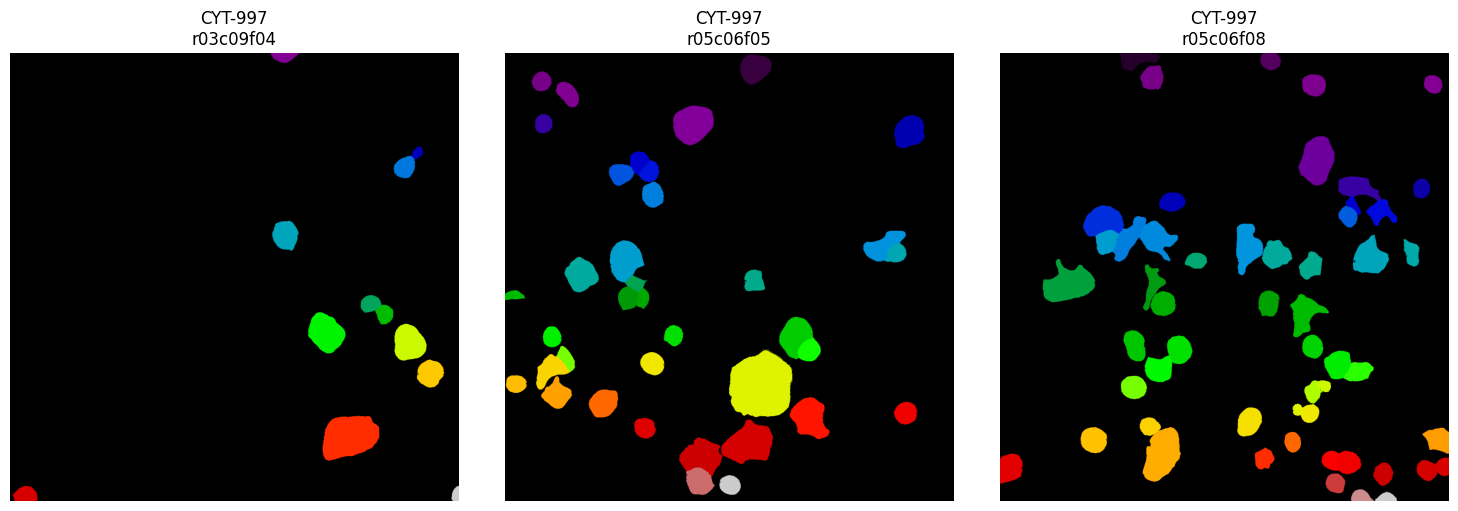

In [ ]:
dmso_ids = train_df[train_df["Drug_Name"] == "DMSO"]["core_id"].tolist()
bam7_ids = train_df[train_df["Drug_Name"] == "BAM7"]["core_id"].tolist()
cyt997_ids = train_df[train_df["Drug_Name"] == "CYT-997"]["core_id"].tolist()

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def obtain_the_mask_figures(core_ids, drug_name, mask_folder):
    fig, axes = plt.subplots(1, len(core_ids), figsize=(5 * len(core_ids), 5))
    if len(core_ids) == 1:
        axes = [axes]

    for i, core_id in enumerate(core_ids):
        path = os.path.join(mask_folder, f"MASK_{core_id}_median_aggregated.tif")
        if not os.path.exists(path):
            print(f"It cannot find the mask with respect to the identity {core_id}")
            continue
        mask = np.array(Image.open(path))
        axes[i].imshow(mask, cmap="nipy_spectral")
        axes[i].set_title(f"{drug_name}\n{core_id}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
obtain_the_mask_figures(dmso_ids[:3], "DMSO", mask_folder)
obtain_the_mask_figures(bam7_ids[:3], "BAM7", mask_folder)
obtain_the_mask_figures(cyt997_ids[:3], "CYT-997", mask_folder)

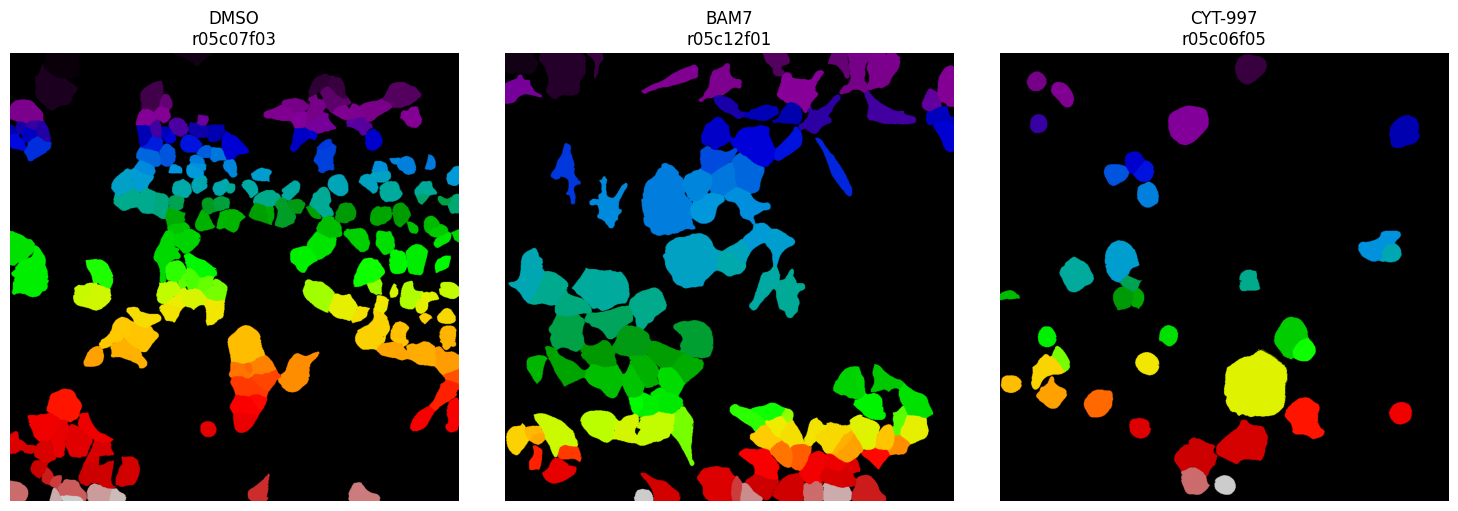

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"

dmso_id = "r05c07f03"
bam7_id = "r05c12f01"
cyt997_id = "r05c06f05"

selected_ids = [dmso_id, bam7_id, cyt997_id]
drug_names = ["DMSO", "BAM7", "CYT-997"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (core_id, drug_name) in enumerate(zip(selected_ids, drug_names)):
    path = os.path.join(mask_folder, f"MASK_{core_id}_median_aggregated.tif")
    if os.path.exists(path):
        mask = np.array(Image.open(path))
        axes[i].imshow(mask, cmap="nipy_spectral")
        axes[i].set_title(f"{drug_name}\n{core_id}")
        axes[i].axis("off")
    else:
        axes[i].set_title(f"{drug_name}\n{core_id} (Not Found)")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


We implement the extracted features on the mask images. The extracted features: area, eccentricity, mean, intensity, solidity, perimeter, coverage, aspect, ratio, containing the average information on the cells.

In [ ]:
def morphological_features(original_image, mask_image):

    if original_image.ndim == 3:
        from skimage.color import rgb2gray
        grayscale = rgb2gray(original_image)
    else:
        grayscale = original_image

    features = [
        "label",
        "area",
        "perimeter",
        "eccentricity",
        "solidity",
        "mean_intensity",
        "max_intensity",
        "min_intensity",
        "centroid",
    ]

    ptzs = regionptzs_table(mask_image, intensity_image=grayscale, properties=features)

    return pd.DataFrame(ptzs)


In [ ]:
from skimage.io import imread

before_fig = imread(r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\downsampled_data\r01c01f01_median_aggregated.tiff")
mask_img = imread(r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks\MASK_r01c01f01_median_aggregated.tif")

df_fts = morphological_features(before_fig, mask_img)
print(df_fts.head())


   label    area   perimeter  eccentricity  solidity  mean_intensity  \
0      1   362.0  105.112698      0.947398  0.811659       26.323204   
1      2   674.0  116.083261      0.818394  0.941341       32.734421   
2      3  2366.0  215.066017      0.872940  0.900647       22.014370   
3      4  5827.0  328.078210      0.731634  0.935914       22.639952   
4      5  2782.0  287.195959      0.959130  0.902661       12.804817   

   max_intensity  min_intensity  centroid-0  centroid-1  
0           62.0            5.0    4.853591  154.806630  
1           55.0           11.0   10.048961  187.053412  
2           53.0            8.0   29.815300  204.840237  
3           78.0            4.0   44.531148  299.957954  
4           38.0            4.0   14.281812  383.346873  


In [ ]:
import os
import re
import pandas as pd
from skimage.io import imread
import numpy as np
from skimage.measure import regionprops, label

downsampled_data_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\downsampled_data"
mask_data_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
metadata_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\metadata_BR00116991.csv"

metadata = pd.read_csv(metadata_path)

def get_the_id_number(filename):
    match = re.search(r'(r\d{2}c\d{2}f\d{2})', filename)
    return match.group(1) if match else None

def search_for_features(before_fig, mask_img):
    mask_id_value = label(mask_img)
    ptzs = regionptzs(mask_id_value, intensity_image=before_fig)
    features = []
    for prop in ptzs:
        features.append({
            'area': prop.area,
            'eccentricity': prop.eccentricity,
            'mean_intensity': prop.mean_intensity,
            'solidity': prop.solidity,
            'perimeter': prop.perimeter,
        })
    return features

overall_fts = []

for fname in os.listdir(image_dir):
    if not fname.endswith(".tiff"):
        continue

    core_id = get_the_id_number(fname)
    if not core_id:
        continue

    pth_as_before = os.path.join(image_dir, fname)
    pth_as_mask = os.path.join(mask_dir, f"MASK_{fname.replace('.tiff', '.tif')}")

    if not os.path.exists(pth_as_mask):
        continue

    try:
        before_fig = imread(pth_as_before)
        mask_img = imread(pth_as_mask)
        fts_average_cell = search_for_features(before_fig, mask_img)

        line_combined = metadata[metadata['core_id'] == core_id]
        if line_combined.empty:
            continue

        drug_name = line_combined.iloc[0]['Metadata_pert_iname']
        for feat in fts_average_cell:
            feat['Drug_Name'] = drug_name
            feat['core_id'] = core_id
            all_features.append(feat)

    except Exception as e:
        print(f"Error processing {fname}: {e}")


df_fts = pd.DataFrame(over_fts)
metadata['core_id'] = metadata['FileName_OrigRNA'].apply(extract_core_id)
full_df = df_fts.merge(metadata, on='core_id', how='left')




In [ ]:
import pandas as pd

full_df.head(10)


,area,eccentricity,mean_intensity,solidity,perimeter,core_id,Unnamed: 0,FileName_OrigRNA,Metadata_ChannelID,Metadata_Plate,...,Metadata_PositionX,Metadata_PositionY,Metadata_PositionZ,Metadata_Row,Metadata_target,Metadata_experiment_type,Metadata_cell_line,Metadata_pert_iname,Metadata_gene,Metadata_pubchem_cid
0,362.0,0.947398,26.323204,0.811659,105.112698,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
1,674.0,0.818394,32.734421,0.941341,116.083261,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
2,2366.0,0.872940,22.014370,0.900647,215.066017,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
3,5827.0,0.731634,22.639952,0.935914,328.078210,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
4,2782.0,0.959130,12.804817,0.902661,287.195959,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
5,877.0,0.781139,6.588369,0.982083,117.355339,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
6,5844.0,0.801746,15.863279,0.959764,309.279221,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
7,1209.0,0.706698,24.469810,0.930716,142.124892,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
8,6967.0,0.797303,19.601694,0.737951,441.847763,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
9,2931.0,0.555497,20.294439,0.929296,227.829473,r01c01f01,0,r01c01f01p01-ch3sk1fk1fl1.tiff,5,BR00116991,...,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from skimage.io import imread
from skimage.measure import regionptzs, label

metadata_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\metadata_BR00116991.csv"
metadata = pd.read_csv(metadata_path)
metadata = metadata[['FileName_OrigRNA', 'Metadata_pert_iname']]
metadata.dropna(inplace=True)

def get_the_id_number(filename):
    match = re.search(r'(r\d{2}c\d{2}f\d{2})', filename)
    return match.group(1) if match else None

def search_for_features(before_fig, mask_img):
    mask_id_value = label(mask_img)
    ptzs = regionptzs(mask_id_value, intensity_image=before_fig)
    features = []
    for prop in ptzs:
        features.append({
            'area': prop.area,
            'eccentricity': prop.eccentricity,
            'mean_intensity': prop.mean_intensity,
            'solidity': prop.solidity,
            'perimeter': prop.perimeter,
        })
    return features

image_dir = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\downsampled_data"
mask_dir = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"

all_features = []
metadata['core_id'] = metadata['FileName_OrigRNA'].apply(get_the_id_number)

for fname in os.listdir(image_dir):
    if not fname.endswith(".tiff"):
        continue

    core_id = get_the_id_number(fname)
    if not core_id:
        continue

    pth_as_before = os.path.join(image_dir, fname)
    pth_as_mask = os.path.join(mask_dir, f"MASK_{fname.replace('.tiff', '.tif')}")

    if not os.path.exists(pth_as_mask):
        continue

    try:
        before_fig = imread(pth_as_before)
        mask_img = imread(pth_as_mask)
        fts_average_cell = search_for_features(before_fig, mask_img)

        line_combined = metadata[metadata['core_id'] == core_id]
        if line_combined.empty:
            continue

        drug_name = line_combined.iloc[0]['Metadata_pert_iname']
        for feat in fts_average_cell:
            feat['Drug_Name'] = drug_name
            feat['core_id'] = core_id
            all_features.append(feat)

    except Exception as e:
        print(f"Error processing {fname}: {e}")

df_fts = pd.DataFrame(all_features)

agg_features = df_fts.groupby(['core_id', 'Drug_Name']).agg(['mean', 'std']).reset_index()
agg_features.columns = ['_'.join(col).strip('_') for col in agg_features.columns.values]

agg_features['Drug_Label'] = LabelEncoder().fit_transform(agg_features['Drug_Name'])

X = agg_features.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y = agg_features['Drug_Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

class Classifier(nn.Module):
    def __init__(self, input_dim, numsc):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, numsc)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
numsc = len(np.unique(y))
model = Classifier(input_dim, numsc)

ctr = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_trch = torch.tensor(X_train, dtype=torch.float32)
y_train_trch = torch.tensor(y_train, dtype=torch.long)
X_test_trch = torch.tensor(X_test, dtype=torch.float32)
y_test_trch = torch.tensor(y_test, dtype=torch.long)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_trch)
    loss = ctr(outputs, y_train_trch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    results_for_val = model(X_test_trch)
    _, predicted = torch.max(results_for_val, 1)

accuracy = (predicted == y_test_trch).float().mean()
print(f"\nPer-image classification accuracy: {accuracy.item():.2f}")

flt_by_names = [LabelEncoder().fit(agg_features['Drug_Name']).classes_[i] for i in sorted(set(y_test).intersection(set(predicted.tolist())))]
print("\nClassification report:")
print(classification_report(y_test, predicted, target_names=flt_by_names, labels=sorted(set(y_test))))

Epoch 1/10, Loss: 5.5295
Epoch 2/10, Loss: 5.5162
Epoch 3/10, Loss: 5.5031
Epoch 4/10, Loss: 5.4901
Epoch 5/10, Loss: 5.4773
Epoch 6/10, Loss: 5.4643
Epoch 7/10, Loss: 5.4510
Epoch 8/10, Loss: 5.4371
Epoch 9/10, Loss: 5.4226
Epoch 10/10, Loss: 5.4074

Per-image classification accuracy: 0.18

Classification report:
               precision    recall  f1-score   support

      CYT-997       0.00      0.00      0.00         2
         DMSO       0.00      0.00      0.00         2
       TG-003       0.00      0.00      0.00         2
        TG-02       0.00      0.00      0.00         2
acetohexamide       0.00      0.00      0.00         2
 brinzolamide       0.00      0.00      0.00         2
   buparlisib       0.00      0.00      0.00         1
    tranilast       0.00      0.00      0.00         2

     accuracy                           0.18       574
    macro avg       0.00      0.01      0.00       574
 weighted avg       0.03      0.18      0.06       574



d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:2642: UserWarning: labels size, 250, does not match size of target_names, 8
  warnings.warn(
d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

In [ ]:
import pandas as pd

agg_features.to_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\aggregated_features", index=False)
agg_features.head()


,core_id,Drug_Name,area_mean,area_std,eccentricity_mean,eccentricity_std,mean_intensity_mean,mean_intensity_std,solidity_mean,solidity_std,perimeter_mean,perimeter_std,Drug_Label
0,r01c01f01,gabapentin-enacarbil,2867.654676,2111.897062,0.689528,0.236467,21.922237,8.862833,0.922245,0.061067,210.334080,104.606898,185
1,r01c01f02,gabapentin-enacarbil,2294.812834,1491.700256,0.710649,0.185107,26.348385,8.029560,0.916179,0.053609,195.130818,74.397331,185
2,r01c01f03,gabapentin-enacarbil,3863.507463,2439.812487,0.712439,0.205594,21.321629,6.620680,0.907611,0.061722,260.546884,99.790327,185
3,r01c01f04,gabapentin-enacarbil,4493.313725,2975.114025,0.754840,0.164301,19.403973,7.352314,0.901847,0.072579,283.734682,115.943046,185
4,r01c01f05,gabapentin-enacarbil,2990.522472,1873.462947,0.715349,0.177292,24.152869,8.025198,0.931379,0.041770,219.847492,82.413558,185


In [ ]:
import os
import re
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.measure import label

original_fig_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\downsampled_data"
mask_data_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"

def get_the_id_number(filename):
    match = re.search(r'(r\d{2}c\d{2}f\d{2})', filename)
    return match.group(1) if match else None

fts_table_crg = []

for fname in os.listdir(mask_data_path):
    if not fname.endswith(".tif"):
        continue

    core_id = get_the_id_number(fname)
    if not core_id:
        continue

    mask_path = os.path.join(mask_data_path, fname)
    try:
        mask_img = imread(mask_path)
        mask_id_value = label(mask_img)
        cell_count = mask_id_value.max()
        coverage = np.count_nonzero(mask_img) / mask_img.size

        fts_table_crg.append({
            'core_id': core_id,
            'cell_count': cell_count,
            'coverage': coverage
        })
    except Exception as e:
        print(f"Error reading mask {fname}: {e}")

df_crg = pd.DataFrame(fts_table_crg)


In [ ]:
merged_df = agg_features.merge(df_crg, on='core_id', how='left')
print(merged_df.head())


     core_id             Drug_Name    area_mean     area_std  \
0  r01c01f01  gabapentin-enacarbil  2867.654676  2111.897062   
1  r01c01f02  gabapentin-enacarbil  2294.812834  1491.700256   
2  r01c01f03  gabapentin-enacarbil  3863.507463  2439.812487   
3  r01c01f04  gabapentin-enacarbil  4493.313725  2975.114025   
4  r01c01f05  gabapentin-enacarbil  2990.522472  1873.462947   

   eccentricity_mean  eccentricity_std  mean_intensity_mean  \
0           0.689528          0.236467            21.922237   
1           0.710649          0.185107            26.348385   
2           0.712439          0.205594            21.321629   
3           0.754840          0.164301            19.403973   
4           0.715349          0.177292            24.152869   

   mean_intensity_std  solidity_mean  solidity_std  perimeter_mean  \
0            8.862833       0.922245      0.061067      210.334080   
1            8.029560       0.916179      0.053609      195.130818   
2            6.620680     

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import label, regionptzs

original_fig_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\downsampled_data"
mask_data_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"

def get_the_id_number(filename):
    match = re.search(r'(r\d{2}c\d{2}f\d{2})', filename)
    return match.group(1) if match else None

ratio_fts_list = []

for fname in os.listdir(mask_data_path):
    if not fname.endswith(".tif"):
        continue

    core_id = get_the_id_number(fname)
    if not core_id:
        continue

    mask_path = os.path.join(mask_data_path, fname)
    try:
        mask_img = imread(mask_path)
        mask_id_value = label(mask_img)
        ptzs = regionptzs(mask_id_value)

        aspect_ratios = []
        for prop in ptzs:
            if prop.minor_axis_length > 0:
                aspect_ratio = prop.major_axis_length / prop.minor_axis_length
                aspect_ratios.append(aspect_ratio)

        if len(aspect_ratios) > 0:
            mean_aspect = np.mean(aspect_ratios)
        else:
            mean_aspect = np.nan

        ratio_fts_list.append({
            'core_id': core_id,
            'aspect_ratio_mean': mean_aspect
        })

    except Exception as e:
        print(f"Error processing {fname}: {e}")

df_ratio = pd.DataFrame(ratio_fts_list)


In [ ]:
merged_df = merged_df.merge(df_ratio, on='core_id', how='left')
print(merged_df.head())

merged_df.to_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\merged_dataset.csv", index=False)

     core_id             Drug_Name    area_mean     area_std  \
0  r01c01f01  gabapentin-enacarbil  2867.654676  2111.897062   
1  r01c01f02  gabapentin-enacarbil  2294.812834  1491.700256   
2  r01c01f03  gabapentin-enacarbil  3863.507463  2439.812487   
3  r01c01f04  gabapentin-enacarbil  4493.313725  2975.114025   
4  r01c01f05  gabapentin-enacarbil  2990.522472  1873.462947   

   eccentricity_mean  eccentricity_std  mean_intensity_mean  \
0           0.689528          0.236467            21.922237   
1           0.710649          0.185107            26.348385   
2           0.712439          0.205594            21.321629   
3           0.754840          0.164301            19.403973   
4           0.715349          0.177292            24.152869   

   mean_intensity_std  solidity_mean  solidity_std  perimeter_mean  \
0            8.862833       0.922245      0.061067      210.334080   
1            8.029560       0.916179      0.053609      195.130818   
2            6.620680     

We find the bahavior of the three different drugs and plot them.

     core_id             Drug_Name  area_mean  area_std  eccentricity_mean  \
0  r01c01f01  gabapentin-enacarbil   0.359416  0.480191           0.714534   
1  r01c01f02  gabapentin-enacarbil   0.251827  0.299804           0.769805   
2  r01c01f03  gabapentin-enacarbil   0.546454  0.575567           0.774490   
3  r01c01f04  gabapentin-enacarbil   0.664742  0.731263           0.885446   
4  r01c01f05  gabapentin-enacarbil   0.382493  0.410842           0.782104   

   eccentricity_std  mean_intensity_mean  mean_intensity_std  solidity_mean  \
0          0.400745             0.290011            0.199426       0.680379   
1          0.230424             0.359510            0.177982       0.643938   
2          0.298362             0.280580            0.141726       0.592468   
3          0.161427             0.250469            0.160554       0.557845   
4          0.204506             0.325036            0.177870       0.735254   

   solidity_std  perimeter_mean  perimeter_std  Drug_Lab

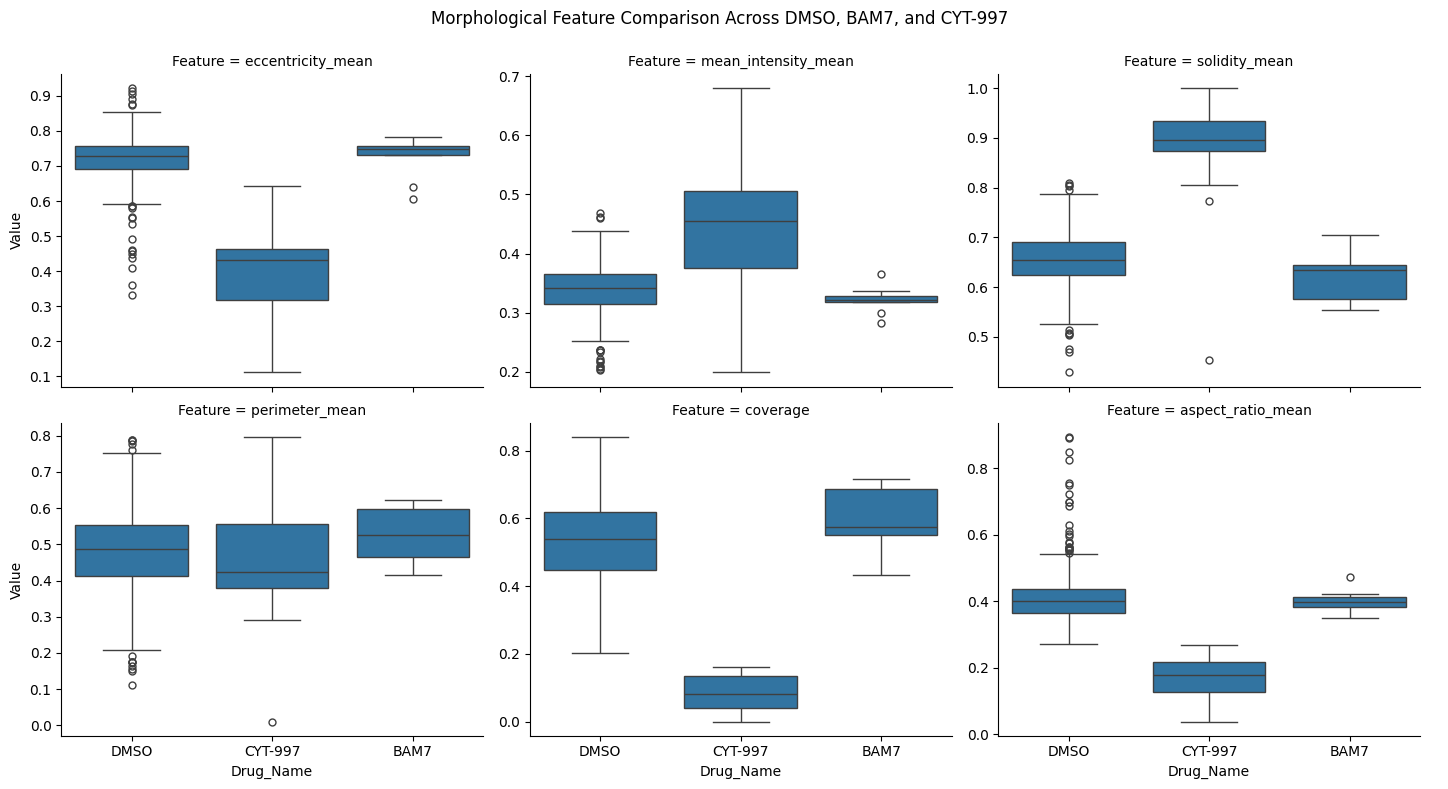

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = merged_df.copy()


clt_fr_num = df.select_dtypes(include='number').columns
scaler = MinMaxScaler()
nml_df_table = df.copy()
nml_df_table[clt_fr_num] = scaler.fit_transform(df[clt_fr_num])
print(nml_df_table.head())

drugs_for_visual = ["DMSO", "BAM7", "CYT-997"]
df_subset = nml_df_table[nml_df_table["Drug_Name"].isin(drugs_for_visual)]

fts_need = [ "eccentricity_mean",  "mean_intensity_mean", "solidity_mean",  "perimeter_mean", "coverage", "aspect_ratio_mean"]
df_combined = df_subset.melt(id_vars=["Drug_Name"], value_vars=fts_need, var_name="Feature", value_name="Value")

g = sns.catplot(
    data=df_combined,
    x="Drug_Name",
    y="Value",
    col="Feature",
    kind="box",
    col_wrap=3,
    sharey=False,
    height=4,
    aspect=1.2
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Morphological Feature Comparison Across DMSO, BAM7, and CYT-997")

plt.show()


d:\anaconda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\nlp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\W\AppData\Local\Temp\ipykernel_8172\1906076212.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)
C:\Users\W\AppData\Local\Temp\ipykernel_8172\1906076212.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


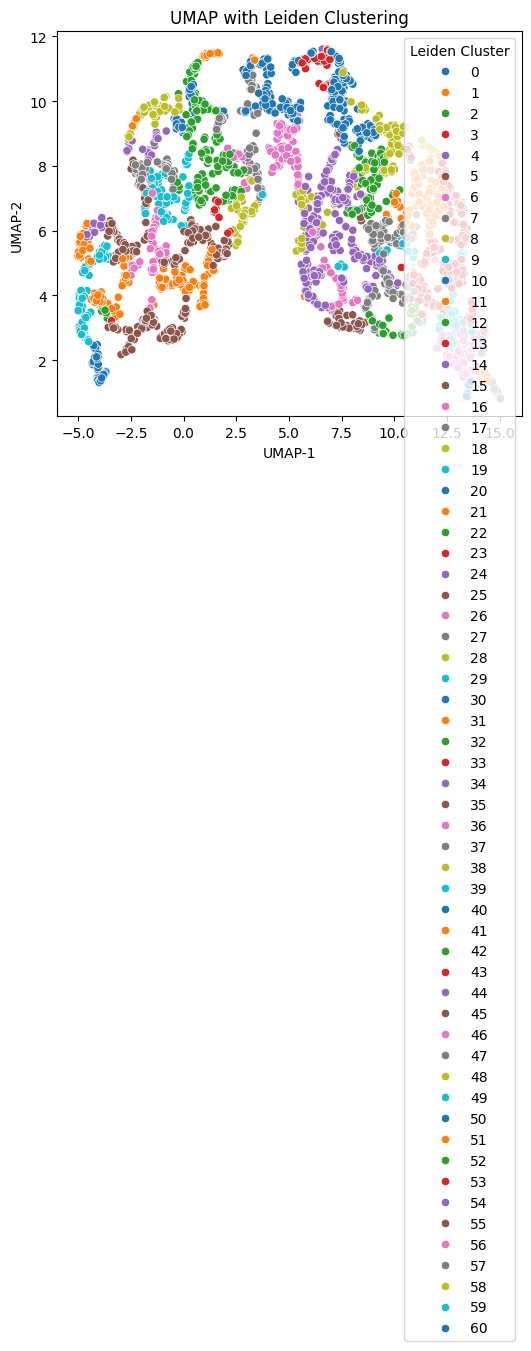

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

features = df.select_dtypes(include='number').drop(columns=['Drug_Label']).values

pca = PCA(n_components=10)
X_pca = pca.fit_transform(features)

md_umap = umap.UMAP(random_state=42)
X_umap = md_umap.fit_transform(X_pca)

adata = sc.AnnData(X_pca)
sc.pp.neighbors(adata, n_neighbors=3)
sc.tl.leiden(adata, resolution=0.5)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=adata.obs['leiden'], palette='tab10')
plt.title('UMAP with Leiden Clustering')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Leiden Cluster')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

pth_fts_agg = r"C:\Users\W\Desktop\Assignments\Data Science\p2\aggregated_features"
agg_features = pd.read_csv(pth_fts_agg)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

train_dfs = []
test_dfs = []

for drug, group in agg_features.groupby("Drug_Name"):
    if len(group) < 2:
        continue
    train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)
    train_dfs.append(train_group)
    test_dfs.append(test_group)

train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

model_encd = LabelEncoder()
train_df['Drug_Label'] = model_encd.fit_transform(train_df['Drug_Name'])
test_df['Drug_Label'] = model_encd.transform(test_df['Drug_Name'])

train_df_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv"
test_df_path = r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv"
train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

train_df_path, test_df_path


('C:\\Users\\W\\Desktop\\Assignments\\Data Science\\p2\\train_df.csv',
 'C:\\Users\\W\\Desktop\\Assignments\\Data Science\\p2\\test_df.csv')

d:\anaconda\envs\nlp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


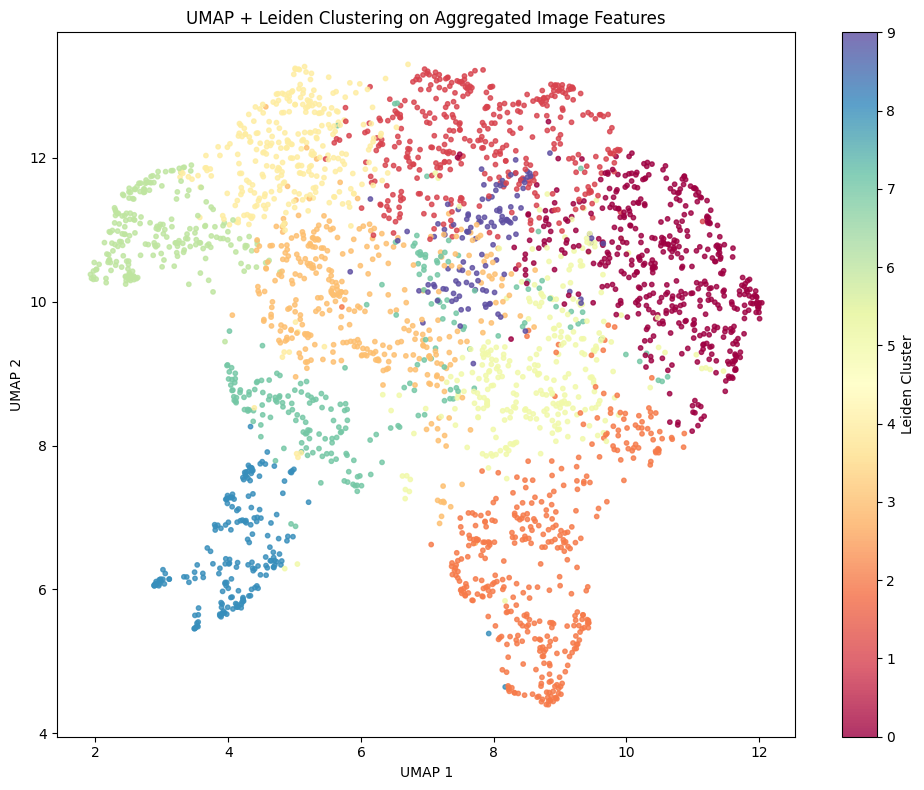

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import umap
import networkx as nx
import igraph as ig
import leidenalg
from sklearn.neighbors import kneighbors_graph


X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])

md_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embd_umap = md_umap.fit_transform(X_all)

ng_means = kneighbors_graph(X_all, n_neighbors=15, mode='connectivity', include_self=False)

graph = ig.Graph.Adjacency((ng_means > 0).toarray().tolist())
graph.simplify()

search_leiden = leidenalg.find_partition(graph, leidenalg.RBConfigurationVertexPartition)
clusters = np.array(search_leiden.membership)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embd_umap[:, 0], embd_umap[:, 1], c=clusters, cmap="Spectral", s=10, alpha=0.8
)
plt.title("UMAP + Leiden Clustering on Aggregated Image Features")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Leiden Cluster")
plt.tight_layout()
plt.show()




In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_train = train_df['Drug_Label'].values

X_test = test_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_test = test_df['Drug_Label'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import os

train_core_ids = train_df['core_id'].unique()
mask_dir = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
mask_for_usage = os.listdir(mask_dir)

ids_same_usage = []
ids_notsame_usage = []

for core_id in train_core_ids:
    found = any(core_id in fname for fname in mask_for_usage)
    if found:
        ids_same_usage.append(core_id)
    else:
        ids_notsame_usage.append(core_id)

ct_same = len(ids_same_usage)
ct_unsame = len(ids_notsame_usage)

ids_same_usage[:5], ct_same, ct_unsame


(['r09c24f06', 'r09c24f01', 'r09c24f09', 'r09c24f03', 'r09c24f05'], 2241, 0)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class DatasetDeal(Dataset):
    def __init__(self, dataframe, mask_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        core_id = row['core_id']
        pthname_msk = f"MASK_{core_id}_median_aggregated.tif"
        mask_path = os.path.join(self.mask_dir, pthname_msk)

        image = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)

        label = row['Drug_Label']
        return image, label

mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
dataset = DatasetDeal(train_df, mask_dir=mask_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class DrugCNN(nn.Module):
    def __init__(self, numsc):
        super(DrugCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, numsc)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

numsc = train_df['Drug_Label'].nunique()
model = DrugCNN(numsc=numsc)

ctr = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ctr(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/10, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 5.1775
Epoch 2/10, Loss: 5.0175
Epoch 3/10, Loss: 4.9404
Epoch 4/10, Loss: 4.8222
Epoch 5/10, Loss: 4.6700
Epoch 6/10, Loss: 4.5162
Epoch 7/10, Loss: 4.3259
Epoch 8/10, Loss: 3.9786
Epoch 9/10, Loss: 3.5136
Epoch 10/10, Loss: 3.0442


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score


test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")
mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
test_dataset = DatasetDeal(test_df, mask_dir=mask_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

acc = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 13.26%


In [ ]:
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")
mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
test_dataset = DatasetDeal(test_df, mask_dir=mask_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

acc = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {acc * 100:.2f}%")

Try using RGB

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class DatasetDeal(Dataset):
    def __init__(self, dataframe, mask_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        core_id = row['core_id']
        pthname_msk = f"MASK_{core_id}_median_aggregated.tif"
        mask_path = os.path.join(self.mask_dir, pthname_msk)

        image = Image.open(mask_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = row['Drug_Label']
        return image, label

mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
dataset = DatasetDeal(train_df, mask_dir=mask_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class DrugCNN(nn.Module):
    def __init__(self, numsc):
        super(DrugCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, numsc)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

numsc = train_df['Drug_Label'].nunique()
model = DrugCNN(numsc=numsc)

ctr = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ctr(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/10, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 5.1294
Epoch 2/10, Loss: 5.0184
Epoch 3/10, Loss: 4.9784
Epoch 4/10, Loss: 4.8795
Epoch 5/10, Loss: 4.7053
Epoch 6/10, Loss: 4.4362
Epoch 7/10, Loss: 4.0553
Epoch 8/10, Loss: 3.5102
Epoch 9/10, Loss: 2.7630
Epoch 10/10, Loss: 2.0257


In [ ]:
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")
mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"
test_dataset = DatasetDeal(test_df, mask_dir=mask_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

acc = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 11.82%


<Figure size 1000x500 with 0 Axes>

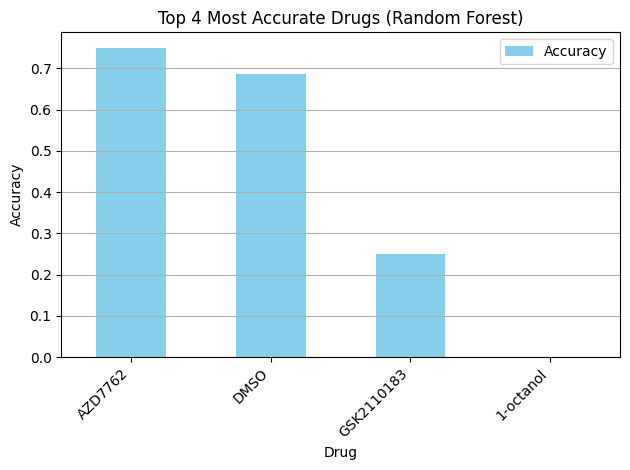

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

test_df = pd.read_csv("C:/Users/W/Desktop/Assignments/Data Science/p2/test_df.csv")

model_encd = LabelEncoder()
model_encd.fit(test_df["Drug_Name"])
test_df["Drug_Label"] = model_encd.transform(test_df["Drug_Name"])

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

class_correct = defaultdict(int)
class_total = defaultdict(int)

for p, t in zip(preds, true_labels):
    class_total[t] += 1
    if p == t:
        class_correct[t] += 1

acc_by_class = {label: class_correct[label] / class_total[label] for label in class_total if class_total[label] > 0}

acc_df = pd.DataFrame({
    "Drug": [model_encd.classes_[i] for i in acc_by_class.keys()],
    "Accuracy": list(acc_by_class.values())
})

acc_df = acc_df.sort_values(by="Accuracy", ascending=False).head(4)
acc_df.set_index("Drug", inplace=True)

plt.figure(figsize=(10, 5))
acc_df.plot(kind='bar', color='skyblue')
plt.title("Top 4 Most Accurate Drugs (Random Forest)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


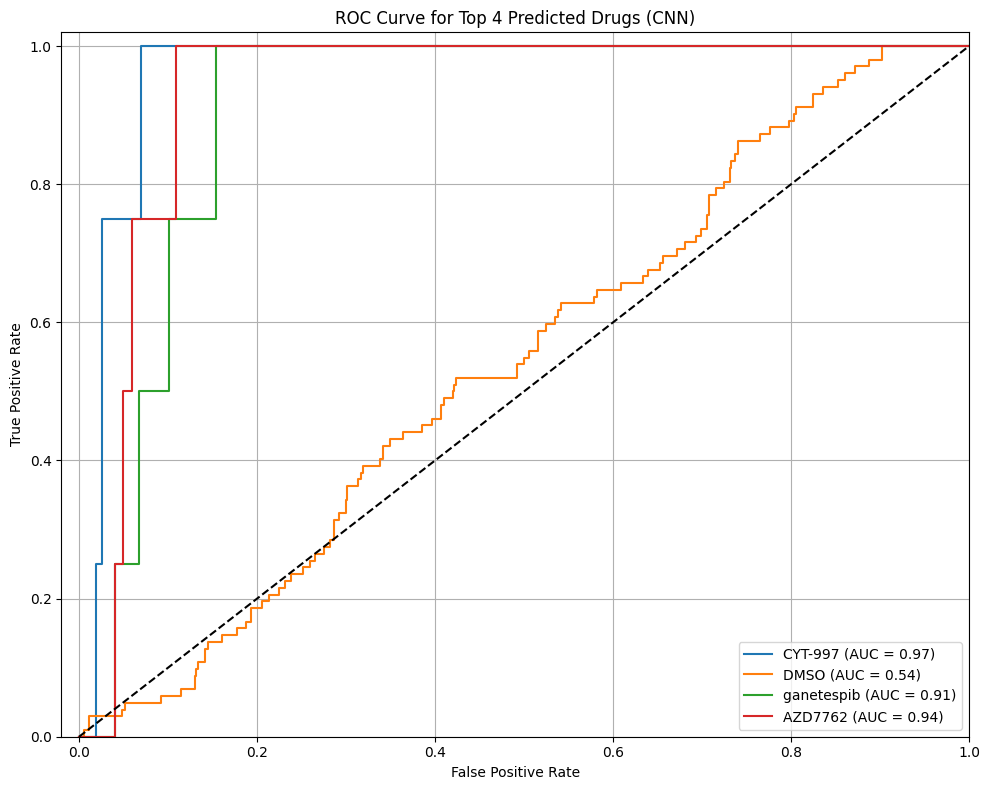

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

class DrugCNN(torch.nn.Module):
    def __init__(self, numsc):
        super(DrugCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(64 * 16 * 16, 128)
        self.fc2 = torch.nn.Linear(128, numsc)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")
mask_folder = r"C:\Users\W\Desktop\Assignments\Data Science\p2\data\Masks"

model_encd = LabelEncoder()
test_df["Drug_Label"] = model_encd.fit_transform(test_df["Drug_Name"])

drug_infos = ["CYT-997", "DMSO", "ganetespib", "AZD7762"]
drug_infos_idx = [model_encd.transform([d])[0] for d in drug_infos]

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


model.eval()

test_dataset = DatasetDeal(test_df, mask_dir=mask_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

pb_stup = []
id_stup = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        pb_stup.append(probs.numpy())
        id_stup.extend(labels.numpy())

pb_stup = np.concatenate(pb_stup)
id_stup = np.array(id_stup)

tk_lb_binary = label_binarize(id_stup, classes=list(range(numsc)))

plt.figure(figsize=(10, 8))
for idx in drug_infos_idx:
    fpr, tpr, _ = roc_curve(tk_lb_binary[:, idx], pb_stup[:, idx])
    roc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_encd.classes_[idx]} (AUC = {roc_value:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 4 Predicted Drugs (CNN)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")

model_encd = LabelEncoder()
train_df['Drug_Label'] = model_encd.fit_transform(train_df['Drug_Name'])
test_df['Drug_Label'] = model_encd.transform(test_df['Drug_Name'])

X_train = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
X_test = test_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_train = train_df['Drug_Label'].values
y_test = test_df['Drug_Label'].values

y_train_binary = (y_train == 0).astype(float)
y_test_binary = (y_test == 0).astype(float)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_trch = torch.tensor(X_train, dtype=torch.float32)
y_train_trch = torch.tensor(y_train_binary.reshape(-1, 1), dtype=torch.float32)
X_test_trch = torch.tensor(X_test, dtype=torch.float32)
y_test_trch = torch.tensor(y_test_binary.reshape(-1, 1), dtype=torch.float32)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 1),
    nn.Sigmoid()
)

ctr = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99)

stt = time.time()
ttl_num_iter = 100
for epoch in range(ttl_num_iter):
    optimizer.zero_grad()
    loss = ctr(model(X_train_trch), y_train_trch)
    loss.backward()
    optimizer.step()
    test_preds = (model(X_test_trch) > 0.5).float()
    accuracy = (test_preds.eq(y_test_trch).sum().item()) / y_test_trch.shape[0]
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{ttl_num_iter}], Training Loss: {loss.item():.4f}, Testing Loss: {1-accuracy:.4f}')

edt = time.time()
running_tm = edt - stt

with torch.no_grad():
    test_preds = (model(X_test_trch) > 0.5).float()
    accuracy = (test_preds.eq(y_test_trch).sum().item()) / y_test_trch.shape[0]

accuracy, running_tm



Epoch [10/100], Training Loss: 0.6406, Testing Loss: 0.4026
Epoch [20/100], Training Loss: 0.6380, Testing Loss: 0.3978
Epoch [30/100], Training Loss: 0.6360, Testing Loss: 0.3930
Epoch [40/100], Training Loss: 0.6343, Testing Loss: 0.3882
Epoch [50/100], Training Loss: 0.6327, Testing Loss: 0.3818
Epoch [60/100], Training Loss: 0.6314, Testing Loss: 0.3770
Epoch [70/100], Training Loss: 0.6301, Testing Loss: 0.3754
Epoch [80/100], Training Loss: 0.6289, Testing Loss: 0.3754
Epoch [90/100], Training Loss: 0.6278, Testing Loss: 0.3754
Epoch [100/100], Training Loss: 0.6267, Testing Loss: 0.3738


(0.6261980830670927, 0.02536749839782715)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")

model_encd = LabelEncoder()
train_df['Drug_Label'] = model_encd.fit_transform(train_df['Drug_Name'])
test_df['Drug_Label'] = model_encd.transform(test_df['Drug_Name'])

X_train = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
X_test = test_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_train = train_df['Drug_Label'].values
y_test = test_df['Drug_Label'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mod_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
mod_random_forest.fit(X_train, y_train)

y_pred = mod_random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=model_encd.classes_))


Random Forest Accuracy: 0.193

Classification Report:
                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00         2
                    2,5-furandimethanol       0.00      0.00      0.00         2
                       2-Oleoylglycerol       0.00      0.00      0.00         2
                                 4-CMTB       0.00      0.00      0.00         2
                      4-methylhistamine       0.00      0.00      0.00         2
                 7-hydroxystaurosporine       0.00      0.00      0.00         2
                                A205804       0.00      0.00      0.00         2
                                 AC-710       0.00      0.00      0.00         2
                                   AK-7       0.00      0.00      0.00         2
                                 ANR-94       0.00      0.00      0.00         2
                                  AR-12       1.00    

d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


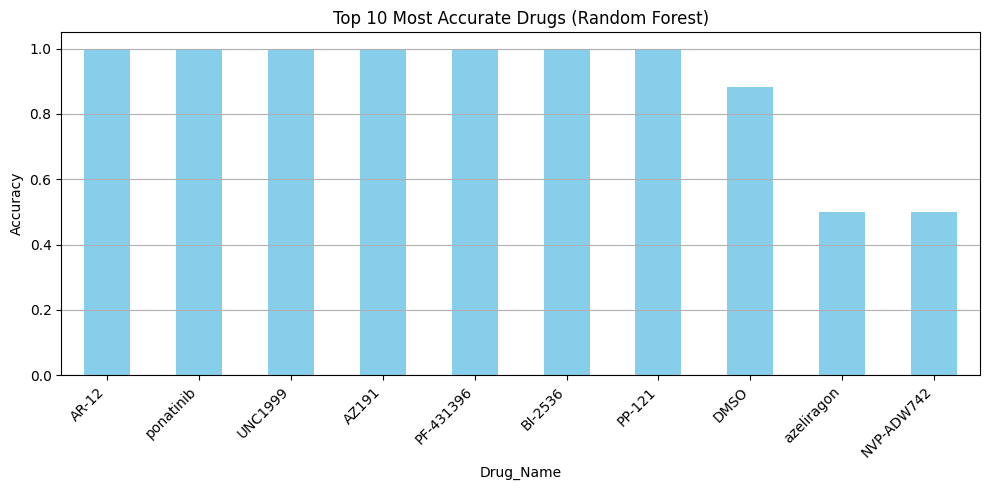

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")

model_encd = LabelEncoder()
train_df['Drug_Label'] = model_encd.fit_transform(train_df['Drug_Name'])
test_df['Drug_Label'] = model_encd.transform(test_df['Drug_Name'])

X_train = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
X_test = test_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_train = train_df['Drug_Label'].values
y_test = test_df['Drug_Label'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mod_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
mod_random_forest.fit(X_train, y_train)

y_pred = mod_random_forest.predict(X_test)

test_df['Predicted_Label'] = y_pred
test_df['True_Label'] = y_test
test_df['Correct'] = test_df['Predicted_Label'] == test_df['True_Label']

test_df['Drug_Name'] = model_encd.inverse_transform(test_df['True_Label'])

score_result_name = test_df.groupby('Drug_Name')['Correct'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
score_result_name.plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Accurate Drugs (Random Forest)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


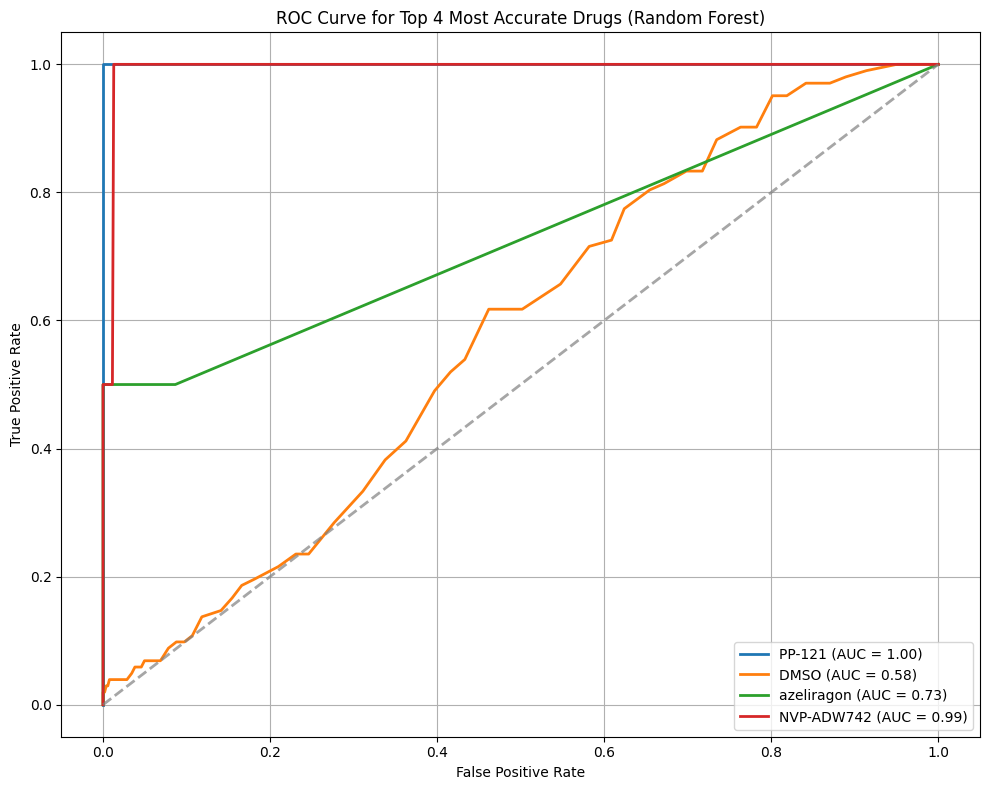

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

y_pred = mod_random_forest.predict(X_test)
test_df['Predicted_Label'] = y_pred
test_df['True_Label'] = y_test
test_df['Correct'] = test_df['Predicted_Label'] == test_df['True_Label']
test_df['Drug_Name'] = model_encd.inverse_transform(test_df['True_Label'])
score_result_name = test_df.groupby('Drug_Name')['Correct'].mean().sort_values(ascending=False).iloc[6:10]
drug_infos_idx = [model_encd.transform([drug])[0] for drug in score_result_name.index]

plt.figure(figsize=(10, 8))
for idx in drug_infos_idx:
    fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
    roc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{model_encd.inverse_transform([idx])[0]} (AUC = {roc_value:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 4 Most Accurate Drugs (Random Forest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Accuracy: 0.193


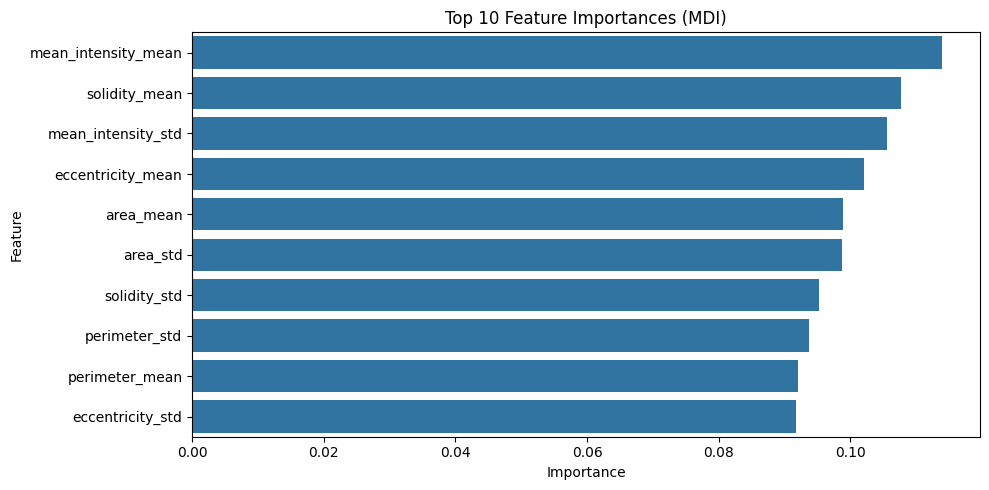

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_value_score, roc_curve
)
from sklearn.inspection import permutation_importance

train_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\train_df.csv")
test_df = pd.read_csv(r"C:\Users\W\Desktop\Assignments\Data Science\p2\test_df.csv")

model_encd = LabelEncoder()
train_df['Drug_Label'] = model_encd.fit_transform(train_df['Drug_Name'])
test_df['Drug_Label'] = model_encd.transform(test_df['Drug_Name'])

X_train = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
X_test = test_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).values
y_train = train_df['Drug_Label'].values
y_test = test_df['Drug_Label'].values
drug_names = model_encd.classes_

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.3f}")


mdi_find = rf.feature_mdi_find_
fts_strc = train_df.drop(columns=['core_id', 'Drug_Name', 'Drug_Label']).columns
sorted_idx = np.argsort(mdi_find)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=mdi_find[sorted_idx][:10], y=fts_strc[sorted_idx][:10])
plt.title("Top 10 Feature mdi_find (MDI)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


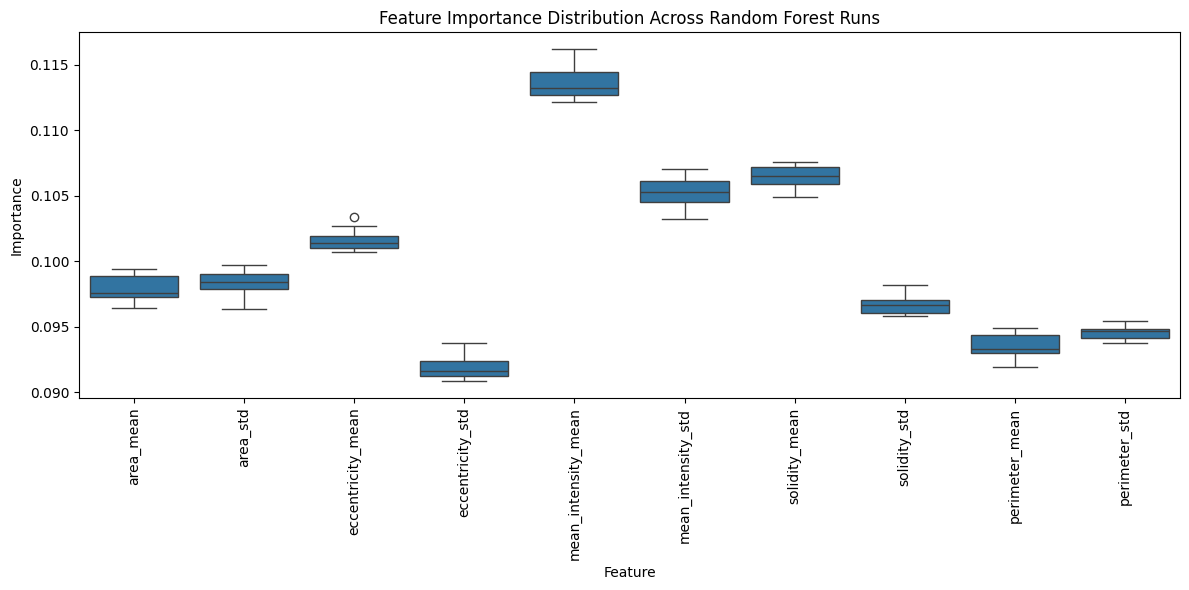

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

mdi_list = []

for seed in range(10):
    rf = RandomForestClassifier(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    mdi_list.append(rf.feature_mdi_find_)

inportance_df = pd.DataFrame(mdi_list, columns=fts_strc)
inportance_df = inportance_df.melt(var_name="Feature", value_name="Importance")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="Feature", y="Importance", data=inportance_df)
plt.xticks(rotation=90)
plt.title("Feature Importance Distribution Across Random Forest Runs")
plt.tight_layout()
plt.show()
